In [1]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [1]:
#!mkdir ../yaml/august-20-2022
#!mkdir ../output/august-20-2022

Same setup at August 15, but increased the ribosome binding rate by an order of magnitude (hopefully to get the curves to flatten out a bit) and also added tRNA abundaces at 99:1 odds.

In [3]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_lens = [300, 300]
cellular_transcript_copy_number = 50
transgene_transcript_copy_numbers = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300, 500]
ribosome_copy_number = 100
total_trna = 1000
ribosome_binding_rates = [1000000.0, 1000000.0]
trna_charging_rate = 100.0
transcript_names = ["cellularProtein", "GFP"]
trna_props = [(0.6, 0.4), (0.9, 0.1), (0.95, 0.05), (0.99, 0.01)]
#codon_comps_1 = (0.9, 0.1)
codon_comps_2 = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]

date = "august-20-2022"

In [8]:
for trna_prop in trna_props:
    for comp in codon_comps_2:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[trna_prop, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [9]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for transgene_copy in transgene_transcript_copy_numbers:
            for seed in range(1, 4):
                cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {transgene_copy} " + \
                  f"{ribosome_copy_number} {total_trna} {ribosome_binding_rates[0]} {ribosome_binding_rates[1]} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
                stream.write(cmd)
                stream.write("\n")

In [4]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = pd.read_csv(f"{path}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

In [5]:
df_master = None
for trna_prop in trna_props:
    df_trna = None
    for codon_comp in codon_comps_2:
        df_codon = None
        for transgene_copy in transgene_transcript_copy_numbers:
            path = f"../output/{date}/two_codon_multi_transcript_{trna_prop[0]}_{trna_prop[1]}_{codon_comp[0]}_{codon_comp[1]}_{trna_prop[0]}_{trna_prop[1]}" + \
                   f"_{cellular_transcript_copy_number}_{transgene_copy}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ribosome_binding_rates[0]}_{ribosome_binding_rates[1]}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 500, 3)
            tmp["transgene_copy"] = transgene_copy
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_codon is not None:
                df_codon = df_codon.append(tmp, ignore_index=True)
            else:
                df_codon = tmp
            df_codon["codon_comp"] = codon_comp[0]
        if df_trna is not None:
            df_trna = df_trna.append(df_codon, ignore_index=True)
        else:
            df_trna = df_codon
        df_trna["trna_prop"] = trna_prop[0]
    if df_master is not None:
        df_master = df_master.append(df_trna, ignore_index=True)
    else:
        df_master = df_trna

df_master

,time,species,protein,delta,transgene_copy,codon_comp,trna_prop
0,50.0,ATA_charged,276.000000,-4.333333,0,0.9,0.60
1,50.0,ATA_uncharged,124.000000,4.333333,0,0.9,0.60
2,50.0,TTT_charged,436.666667,10.000000,0,0.9,0.60
3,50.0,TTT_uncharged,163.333333,-10.000000,0,0.9,0.60
4,50.0,__cellularProtein_rbs,49.000000,0.000000,0,0.9,0.60
...,...,...,...,...,...,...,...
5306,500.0,TTT_uncharged,0.666667,0.166667,500,0.1,0.99
5307,500.0,__GFP_rbs,497.333333,-1.666667,500,0.1,0.99
5308,500.0,__cellularProtein_rbs,50.000000,0.000000,500,0.1,0.99
5309,500.0,free ribosome,0.000000,0.000000,500,0.1,0.99


In [6]:
df_master["transgene_copy"] = df_master["transgene_copy"].replace([0], 1)

pivot = df_master[(df_master.time == 500.0)]
pivot = pivot.pivot(index = ["codon_comp", "transgene_copy", "trna_prop"], columns = "species", values = "protein").reset_index()
pivot["GFP"] = pivot["GFP"].fillna(0)
#pivot["cellularProtein_transformed"] = pivot["cellularProtein"] / pivot["cellularProtein"].max()
pivot["cellularProtein_transformed"] = pivot["cellularProtein"].groupby([pivot.codon_comp, pivot.trna_prop]).transform(lambda x: x/x.max())
pivot["GFP_transformed"] = pivot["GFP"] / (pivot["GFP"] + pivot["cellularProtein"])
pivot["Percent_opt"] = (pivot["codon_comp"] / 0.9 * 100).round().astype("int")
pivot["exp_cellularProtein"] = np.exp(pivot["cellularProtein_transformed"])

pivot_d = df_master[(df_master.time == 50.0)]
pivot_d = pivot_d.pivot(index = ["codon_comp", "transgene_copy", "trna_prop"], columns = "species", values = "delta").reset_index()
pivot_d["GFP"] = pivot_d["GFP"].fillna(0)
#pivot["cellularProtein_transformed"] = pivot["cellularProtein"] / pivot["cellularProtein"].max()
pivot_d["cellularProtein_transformed"] = pivot_d["cellularProtein"].groupby([pivot_d.codon_comp, pivot_d.trna_prop]).transform(lambda x: x/x.max())
pivot_d["GFP_transformed"] = pivot_d["GFP"] / (pivot_d["GFP"] + pivot_d["cellularProtein"])
pivot_d["Percent_opt"] = (pivot_d["codon_comp"] / 0.9 * 100).round().astype("int")
pivot_d["exp_cellularProtein"] = np.exp(pivot_d["cellularProtein_transformed"])
#pivot_d

In [7]:
pivot_d

species,codon_comp,transgene_copy,trna_prop,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,cellularProtein_transformed,GFP_transformed,Percent_opt,exp_cellularProtein
0,0.1,1,0.60,-4.333333,4.333333,0.000000,10.000000,-10.000000,NaN,0.000000,3825.000000,5.333333,1.000000,0.000000,11,2.718282
1,0.1,1,0.90,-2.000000,2.000000,0.000000,-11.666667,11.666667,NaN,0.000000,3795.000000,1.666667,1.000000,0.000000,11,2.718282
2,0.1,1,0.95,-3.666667,3.666667,0.000000,27.666667,-27.666667,NaN,-1.000000,3759.000000,0.000000,1.000000,0.000000,11,2.718282
3,0.1,1,0.99,-0.333333,0.333333,0.000000,19.666667,-19.666667,NaN,0.000000,3519.000000,6.333333,1.000000,0.000000,11,2.718282
4,0.1,10,0.60,-2.000000,2.000000,159.666667,-2.666667,2.666667,0.000000,-0.333333,3645.000000,2.000000,0.952941,0.041966,11,2.593326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.9,300,0.99,-0.333333,0.333333,652.666667,-0.333333,0.333333,-3.000000,0.000000,23.666667,0.000000,0.006725,0.965007,100,1.006748
295,0.9,500,0.60,4.666667,-4.666667,4207.666667,-6.666667,6.666667,-1.666667,0.000000,46.000000,0.333333,0.012026,0.989186,100,1.012099
296,0.9,500,0.90,-3.333333,3.333333,4392.000000,-9.666667,9.666667,1.333333,0.000000,41.000000,-0.333333,0.010804,0.990751,100,1.010862
297,0.9,500,0.95,-3.333333,3.333333,2826.666667,-17.666667,17.666667,1.666667,0.333333,26.333333,0.666667,0.007005,0.990770,100,1.007030


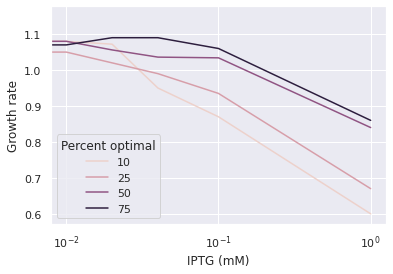

In [17]:
sns.set_theme(color_codes=True)
cam_results = pd.read_csv("../processed_data/cameron_deop_results_aug.csv")

sns.lineplot(data = cam_results, x = "IPTG", y = "growth_rate", hue = "perc_opt")
plt.xscale("log")
plt.xlabel("IPTG (mM)")
plt.ylabel("Growth rate")
plt.legend(title="Percent optimal")
plt.savefig(f"../plots/{date}/gfp_deop_ex.png")

In [32]:
rcParams['figure.figsize'] = [8, 6]

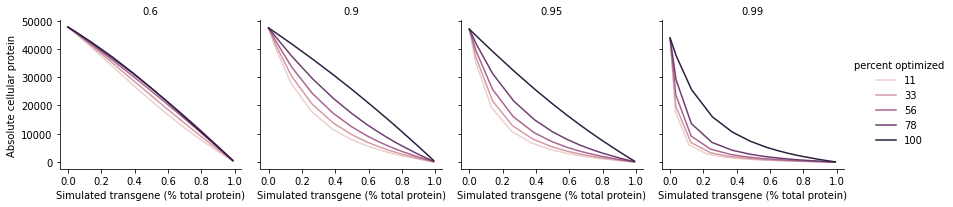

In [76]:
g = sns.FacetGrid(pivot, col="trna_prop", col_wrap=4, sharey=True)
g.map_dataframe(sns.lineplot, "GFP_transformed", "cellularProtein", hue="Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene (% total protein)", "Absolute cellular protein")  
g.add_legend(title="percent optimized")

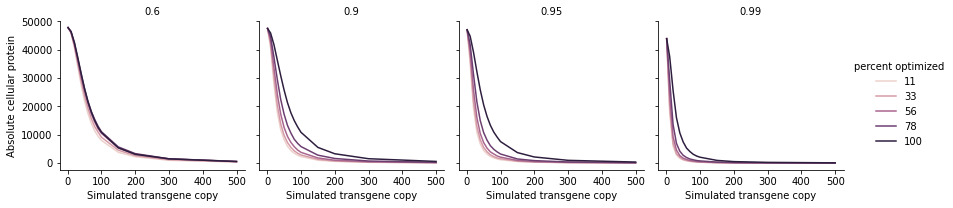

In [77]:
g = sns.FacetGrid(pivot, col="trna_prop", col_wrap=4, sharey=True)
g.map_dataframe(sns.lineplot, "transgene_copy", "cellularProtein", hue="Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene copy", "Absolute cellular protein")
g.add_legend(title="percent optimized")

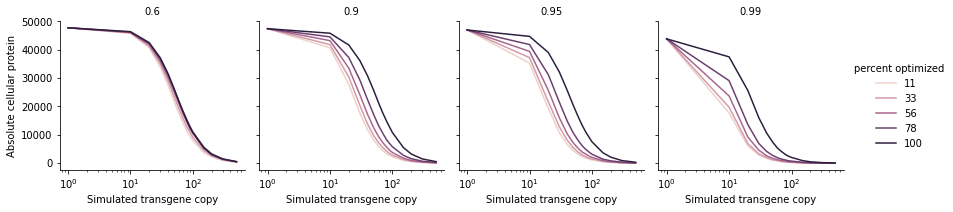

In [92]:
g = sns.FacetGrid(pivot, col="trna_prop", col_wrap=4, sharey=True)
g.map_dataframe(sns.lineplot, "transgene_copy", "cellularProtein", hue="Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene copy", "Absolute cellular protein")  
plt.xscale("log")
g.add_legend(title="percent optimized")

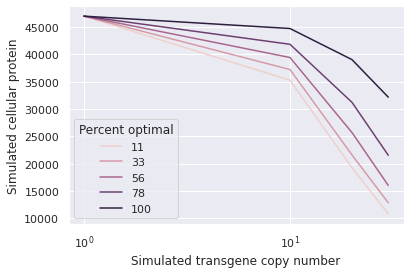

In [19]:
rcParams['figure.figsize'] = [6, 4]
pivot_95 = pivot[(pivot.trna_prop == 0.95) & (pivot.transgene_copy < 40)]
sns.lineplot(data = pivot_95, x = "transgene_copy", y = "cellularProtein", hue = "Percent_opt")
plt.xscale("log")
plt.ylabel("Simulated cellular protein")
plt.xlabel("Simulated transgene copy number")
plt.legend(title="Percent optimal")
plt.savefig(f"../plots/{date}/gfp_sim_95.png", bbox_inches=")

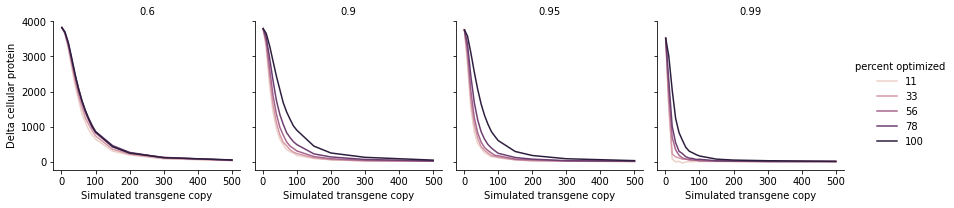

In [79]:
g = sns.FacetGrid(pivot_d, col="trna_prop", col_wrap=4, sharey=True)
g.map_dataframe(sns.lineplot, "transgene_copy", "cellularProtein", hue="Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene copy", "Delta cellular protein")  
g.add_legend(title="percent optimized")

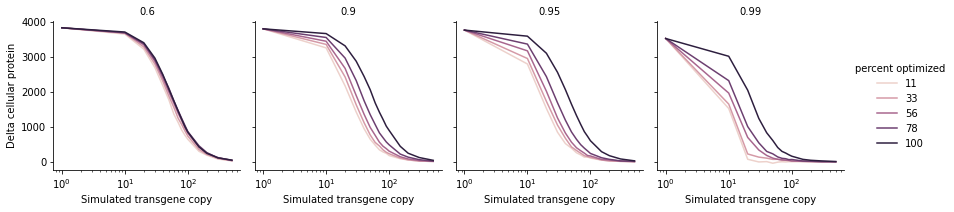

In [93]:
g = sns.FacetGrid(pivot_d, col="trna_prop", col_wrap=4, sharey=True)
g.map_dataframe(sns.lineplot, "transgene_copy", "cellularProtein", hue="Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene copy", "Delta cellular protein")  
plt.xscale("log")
g.add_legend(title="percent optimized")

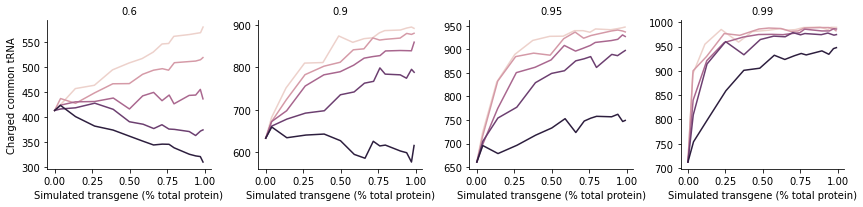

In [16]:
g = sns.FacetGrid(pivot, col="trna_prop", col_wrap=4, sharey=False)
g.map_dataframe(sns.lineplot, "GFP_transformed", "TTT_charged", hue = "Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene (% total protein)", "Charged common tRNA")  

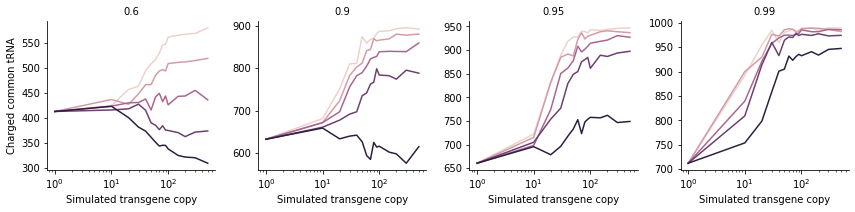

In [94]:
g = sns.FacetGrid(pivot, col="trna_prop", col_wrap=4, sharey=False)
g.map_dataframe(sns.lineplot, "transgene_copy", "TTT_charged", hue = "Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene copy", "Charged common tRNA")
plt.xscale("log")

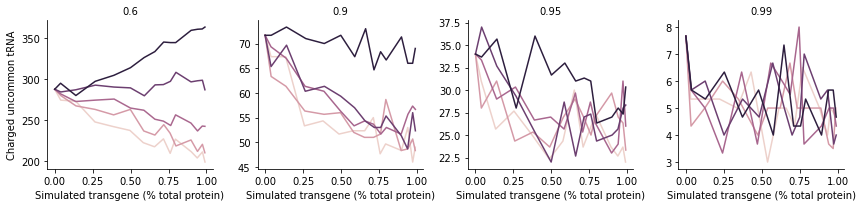

In [17]:
g = sns.FacetGrid(pivot, col="trna_prop", col_wrap=4, sharey=False)
g.map_dataframe(sns.lineplot, "GFP_transformed", "ATA_charged", hue = "Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene (% total protein)", "Charged uncommon tRNA")  

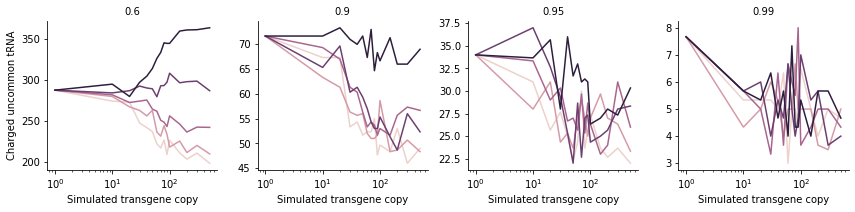

In [95]:
g = sns.FacetGrid(pivot, col="trna_prop", col_wrap=4, sharey=False)
g.map_dataframe(sns.lineplot, "transgene_copy", "ATA_charged", hue = "Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene copy", "Charged uncommon tRNA")  
plt.xscale("log")

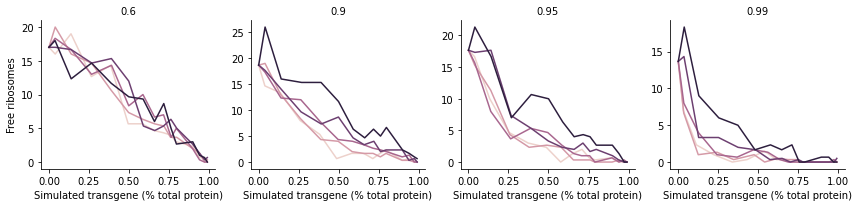

In [18]:
g = sns.FacetGrid(pivot, col="trna_prop", col_wrap=4, sharey=False)
g.map_dataframe(sns.lineplot, "GFP_transformed", "free ribosome", hue = "Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene (% total protein)", "Free ribosomes")  

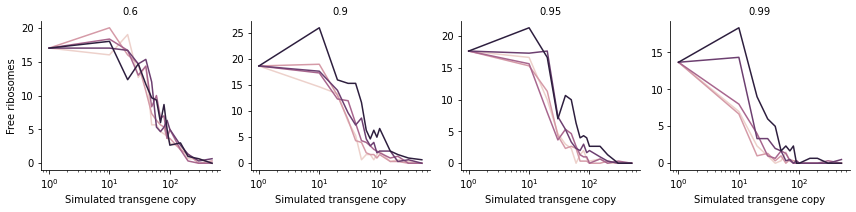

In [96]:
g = sns.FacetGrid(pivot, col="trna_prop", col_wrap=4, sharey=False)
g.map_dataframe(sns.lineplot, "transgene_copy", "free ribosome", hue = "Percent_opt")
g.set_titles("{col_name}")
g.set_axis_labels("Simulated transgene copy", "Free ribosomes")  
plt.xscale("log")